# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

df = pd.read_csv('user-item-interactions.csv')
df_content = pd.read_csv('articles_community.csv')

df.head()

,Unnamed: 0,article_id,title,email
0,0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
df.shape[0]

45993

In [3]:
df_content.head()

,Unnamed: 0,doc_body,doc_description,doc_full_name,doc_status,article_id
0,3,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,5,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,7,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,8,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,12,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [4]:
df_content.shape[0]

1056

In [5]:
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [6]:
row = df_content.loc[df_content['article_id'] == 10] # choose article_id = 10

for word in row['doc_body']: # the doc_body of article 10 
    print(word)

OFFLINE-FIRST IOS APPS WITH SWIFT & PART 1: THE DATASTOREJason H. Smith / January 25, 2016This walk-through is a sequel to Apple’s well-known iOS programmingintroduction, Start Developing iOS Apps (Swift) . Apple’s introduction walks us through the process of building the UI, data,and logic of an example food tracker app, culminating with a section on datapersistence: storing the app data as files in the iOS device.This series picks up where that document leaves off: syncing data betweendevices, through the cloud, with an offline-first design. You will achieve thisusing open source tools and the free IBM Cloudant service.This document is the first in the series, showing you how to use the CloudantSync datastore, CDTDatastore , for FoodTracker on the iOS device. Subsequent posts will cover syncing to thecloud and other advanced features such as accounts and data management.TABLE OF CONTENTS 1. Getting Started 2. CocoaPods 1. Learning Objectives     2. Install CocoaPods on your Mac     3

In [7]:
for word in row['doc_description']: # read the doc_description 
    print(word)

Apple's sample app, Food Tracker, taught you iOS. Now, take it further and sync data between devices, through the cloud, with an offline-first design.


In [8]:
for word in row['doc_full_name']: # read the doc_full_name 
    print(word)

Offline-First iOS Apps with Swift & Cloudant Sync; Part 1: The Datastore


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

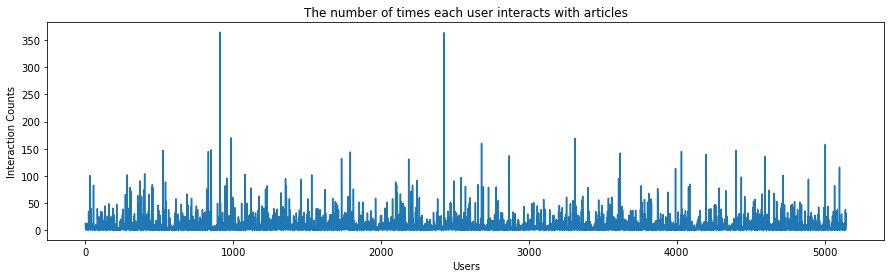

In [9]:
interation_counts = df.groupby('email')['article_id'].count().values
plt.figure(figsize=(15,4))
plt.plot(interation_counts)
plt.xlabel('Users')
plt.ylabel('Interaction Counts')
plt.title('The number of times each user interacts with articles')
plt.show()

In [10]:
# Fill in the median and maximum number of user_article interactions below
median_val = df.groupby('email')['article_id'].count().median()
max_views_by_user = df.groupby('email')['article_id'].count().max()

In [11]:
print('median',median_val) # meaning 50% of individuals interact with 3 or fewer.
print('max',max_views_by_user) # meaning the maximum number of user-article interactions by any 1 user is 364.

median 3.0
max 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [12]:
# Find and explore duplicate articles
df_content[df_content.duplicated(['article_id'])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [13]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(['article_id'], inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [14]:
unique_articles = len(df.article_id.value_counts())
total_articles = df_content.article_id.nunique()
unique_users = df.email.nunique()
user_article_interactions = len(df)

In [15]:
print('unique_articles', unique_articles)
print('total_articles', total_articles)
print('unique_users', unique_users)
print('user_article_interactions', user_article_interactions)

unique_articles 714
total_articles 1051
unique_users 5148
user_article_interactions 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [16]:
df.article_id.value_counts().head() 

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

In [17]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [18]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [19]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df['title'].value_counts().reset_index().head(n)['index'])
        
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles_ids - (list) A list of ids of the top 'n' article titles 
    
    '''
    top_articles_ids = list(df.article_id.value_counts().reset_index().head(n)['index'])
 
    return top_articles_ids # Return the top article ids

In [20]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [21]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    article_id = df.sort_values('article_id').drop_duplicates('article_id').article_id.values
    
    user_id = df.drop_duplicates('user_id').user_id.values
    
    user_item = pd.DataFrame(data = 0, columns=article_id, index=user_id)
    
    data = np.vstack({tuple(row) for row in df[['user_id', 'article_id']].values})
    
    for row in data:
        
        user_item.loc[row[0]][row[1]] = 1
        
    return user_item 

user_item = create_user_item_matrix(df)

/var/folders/1z/xq91ntj140l28h3p6gk9tthm0000gn/T/ipykernel_33426/565762084.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  data = np.vstack({tuple(row) for row in df[['user_id', 'article_id']].values})


In [22]:
user_item

,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
def pearson_corr(x, y):
    '''
    INPUT
    x - an array of matching length to array y
    y - an array of matching length to array x
    OUTPUT
    corr - the pearson correlation coefficient for comparing x and y
    '''
    # Compute Mean Values
    mean_x, mean_y = np.sum(x)/len(x), np.sum(y)/len(y) 
    
    x_diffs = x - mean_x
    y_diffs = y - mean_y
    numerator = np.sum(x_diffs*y_diffs)
    denominator = np.sqrt(np.sum(x_diffs**2))*np.sqrt(np.sum(y_diffs**2))
        
    corr = numerator/denominator
                            
    return corr

`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [24]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity = user_item[user_item.index == user_id].dot(user_item.T)
    # sort by similarity
    # create list of just the ids
    most_similar_users = similarity.sort_values(user_id, axis=1, ascending=False).columns.tolist()
    # remove the own user's id
    most_similar_users.remove(user_id)
    return most_similar_users # return a list of the users in order from most to least similar

In [25]:
find_similar_users(10)[:5] #top 5 similar users of user with id 10. 

[3354, 3697, 49, 3764, 98]

In [26]:
df

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5
...,...,...,...
45988,1324.0,ibm watson facebook posts for 2015,5146
45989,142.0,neural networks for beginners: popular types a...,5146
45990,233.0,bayesian nonparametric models – stats and bots,5147
45991,1160.0,analyze accident reports on amazon emr spark,5148


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [27]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = df[df['article_id'].isin(article_ids)]['title'].drop_duplicates().values.tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    # a list of the article ids seen by the user
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.tolist()
    
    # change data type into string
    for i in range(len(article_ids)):
        
        article_ids[i] = article_ids[i]
        
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10): # m - the number of recommendations you want for the user
    ''' 
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    similar_users = find_similar_users(user_id)
    
    recommended_articles = []
    
    seen_article_ids = get_user_articles(user_id)[0]
    
    for user in similar_users:
        
        article_ids = get_user_articles(user)[0]
        
        recommended_articles.extend(list(set(seen_article_ids) ^ set(article_ids)))
        
    recs = recommended_articles[:m]
    
    return recs # return your recommendations for this user_id

In [28]:
user_user_recs(1, 10)

[151.0, 1025.0, 2.0, 517.0, 12.0, 524.0, 14.0, 525.0, 16.0, 26.0]

In [29]:
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'jupyter notebook tutorial',
 'shaping data with ibm data refinery',
 'new shiny cheat sheet and video tutorial',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'data tidying in data science experience',
 'using machine learning to predict parking difficulty',
 'data science platforms are on the rise and ibm is leading the way']

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [30]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
                    

    '''
    colName = ['neighbor_id', 'similarity', 'num_interactions']
    neighbors_df = pd.DataFrame(columns = colName)
    
    # Your code here
    # compute similarity of each user to the provided user
    similarity = np.dot(
        np.array(user_item[user_item.index == user_id]), np.array(user_item).T)
    similarity = pd.Series(
        similarity.reshape(-1,).tolist(), index=user_item.index)
    
    # compute num_interactions
    num_interactions = df.groupby(['user_id'])['article_id'].count()[user_item.index]

    # produce neighbors_df 
    neighbors_df = pd.DataFrame({'neighbor_id': user_item.index, 'similarity': similarity,
                                 'num_interactions': num_interactions}).set_index('neighbor_id')
    
    # drop user_id itself
    neighbors_df = neighbors_df.drop([user_id])
    
    # sort by similarity and num_interactions
    neighbors_df = neighbors_df.sort_values(
        ['similarity', 'num_interactions'], ascending=[False, False]).reset_index()
    
    return neighbors_df # Return the dataframe specified in the doc_string

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    top_df = get_top_sorted_users(user_id)
    user_id_list = top_df['neighbor_id'].values.tolist()
    recs = []
    name_ids = []

    exp_article_ids = list(set(df[df['user_id'] == user_id]['article_id'].values.tolist()))

    for user in user_id_list:
        recs += df[df['user_id'] == user]['article_id'].values.tolist()

    recs = list(set(recs))
    recs = [ x for x in recs if x not in exp_article_ids ]

    recs = df[df.article_id.isin(recs)][['article_id','title']].drop_duplicates().head(m)
    rec_ids = recs['article_id'].values.tolist()
    rec_names = recs['title'].values.tolist()
    
    return rec_ids, rec_names

In [31]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1430.0, 1314.0, 1429.0, 1338.0, 1276.0, 1432.0, 593.0, 1185.0, 993.0, 14.0]

The top 10 recommendations for user 20 are the following article names:
['using pixiedust for fast, flexible, and easier data analysis and experimentation', 'healthcare python streaming application demo', 'use deep learning for image classification', 'ml optimization using cognitive assistant', 'deploy your python model as a restful api', 'visualize data with the matplotlib library', 'upload files to ibm data science experience using the command line', 'classify tumors with machine learning', 'configuring the apache spark sql context', 'got zip code data? prep it for analytics. – ibm watson data lab – medium']


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [33]:
# quick look at the matrix
user_item.head()

,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [34]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item)# use the built in to get the three matrices

**The matrices have larger size compared to the ones in tutorial.** 
- Since the user-item_matrix is really sparse in a real life situation, we probably wanna switch from traditional SVD method to the Funk SVD method which performs better on a sparse dataset like the one in our case. 
- However, by performing a normal SVD, we can have a sense of how well our recommendation engine performs before hand. SVD can allow us to predict a rating for every user-item pair.Through the ratings, we pick the top rated items and recommend to our users. 

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

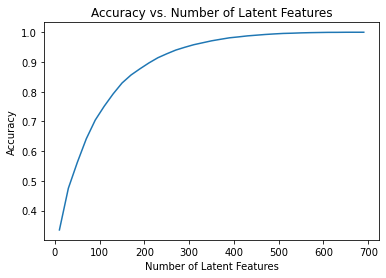

In [37]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [38]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = df_test['user_id'].unique().tolist()
    test_arts = df_test['article_id'].unique().tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

/var/folders/1z/xq91ntj140l28h3p6gk9tthm0000gn/T/ipykernel_33426/565762084.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  data = np.vstack({tuple(row) for row in df[['user_id', 'article_id']].values})


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [39]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [40]:
row_idxs = user_item_train.index.isin(test_idx)
col_idxs = user_item_train.columns.isin(test_arts)
u_test = u_train[row_idxs, :]
vt_test = vt_train[:, col_idxs]

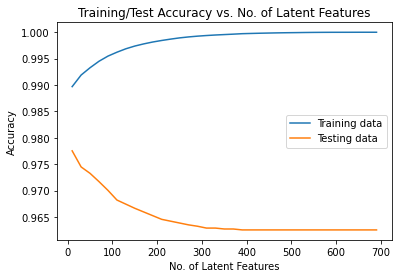

In [41]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

num_latent_feats = np.arange(10,700+10,20)
train_sum_errs = []
test_sum_errs = []

user_intersection_train_test = df_test[df_test['user_id'].isin(df_train['user_id'])].dropna()['user_id'].unique()
user_intersection_train_test_matrix = user_item_test[user_item_test.index.isin(user_intersection_train_test)]

for k in num_latent_feats:
    # restructure latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # compute dot product
    user_item_train_new = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_new = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction 
    train_err = np.subtract(user_item_train, user_item_train_new)
    test_err = np.subtract(user_intersection_train_test_matrix, user_item_test_new)
    
    # total errors 
    train_err = np.sum(np.sum(np.abs(train_err)))
    test_err = np.sum(np.sum(np.abs(test_err)))
    train_sum_errs.append(train_err)
    test_sum_errs.append(test_err)
    
plt.plot(num_latent_feats, 1 - np.array(train_sum_errs)/(user_item_train.shape[0] 
                                                         * user_intersection_train_test_matrix.shape[1]), label='Training data')
plt.plot(num_latent_feats, 1 - np.array(test_sum_errs)/(user_intersection_train_test_matrix.shape[0] 
                                                        * user_intersection_train_test_matrix.shape[1]), label='Testing data')
plt.xlabel('No. of Latent Features')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training/Test Accuracy vs. No. of Latent Features')
plt.show()